In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/list.csv
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00022622.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00017729.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00023587.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00024853.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00009451.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00011286.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00007604.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00026712.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00021320.jpg
/kaggle/input/makeup-lips-segmentation-28k-samples/set

In [3]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

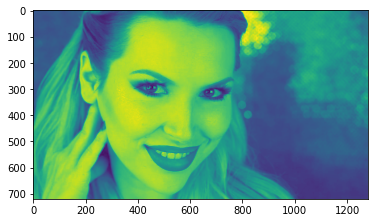

In [5]:
img = plt.imread('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/image00000011.jpg')
plt.imshow(img[..., 0]);

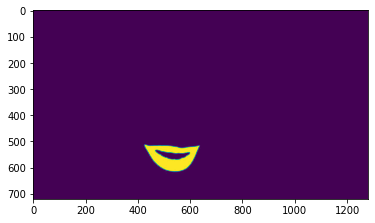

In [6]:
img = plt.imread('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00000011.png')
plt.imshow(img[..., 1]);

In [7]:
IMAGES_PATH = '/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/'
MASKS_PATH = '/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask'

In [8]:
imgs_set = set(os.listdir(IMAGES_PATH))
masks_set = set(os.listdir(MASKS_PATH))

imgs_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in imgs_set)
masks_set = set(''.join(filter(lambda x: x.isdigit(), i)) for i in masks_set)

In [9]:
len(imgs_set), len(masks_set)

(28594, 28540)

In [10]:
len(imgs_set.difference(masks_set)), len(masks_set.difference(imgs_set))

(54, 0)

In [11]:
not_mask = imgs_set.difference(masks_set)

not_mask = [f'image{i}.jpg' for i in not_mask]
not_mask

['image00010770.jpg',
 'image00010732.jpg',
 'image00010756.jpg',
 'image00010751.jpg',
 'image00010761.jpg',
 'image00010717.jpg',
 'image00010743.jpg',
 'image00010745.jpg',
 'image00010767.jpg',
 'image00010805.jpg',
 'image00010801.jpg',
 'image00010768.jpg',
 'image00010747.jpg',
 'image00010806.jpg',
 'image00010736.jpg',
 'image00010724.jpg',
 'image00010759.jpg',
 'image00010776.jpg',
 'image00010781.jpg',
 'image00010813.jpg',
 'image00010793.jpg',
 'image00010744.jpg',
 'image00010742.jpg',
 'image00010735.jpg',
 'image00010721.jpg',
 'image00010807.jpg',
 'image00010752.jpg',
 'image00010737.jpg',
 'image00010810.jpg',
 'image00010763.jpg',
 'image00010733.jpg',
 'image00010802.jpg',
 'image00010766.jpg',
 'image00010769.jpg',
 'image00010803.jpg',
 'image00010795.jpg',
 'image00010764.jpg',
 'image00010773.jpg',
 'image00010788.jpg',
 'image00010783.jpg',
 'image00010804.jpg',
 'image00010811.jpg',
 'image00010799.jpg',
 'image00010718.jpg',
 'image00010719.jpg',
 'image000

In [12]:
list_df = pd.read_csv('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/list.csv')

In [13]:
list_df = list_df[~list_df.filename.isin(not_mask)]

In [14]:
list_df['filename'] = '../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/' + list_df['filename']
list_df['mask'] = '../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/' + list_df['mask']


In [15]:
list_df['width'].value_counts()

1280    28540
Name: width, dtype: int64

In [16]:
list_df['height'].value_counts()

720    27691
675      849
Name: height, dtype: int64

In [17]:
list_df['class'].value_counts()

Lips    28540
Name: class, dtype: int64

In [18]:
list_df[['filename','mask']]

filename  \
0      ../input/makeup-lips-segmentation-28k-samples/...   
1      ../input/makeup-lips-segmentation-28k-samples/...   
2      ../input/makeup-lips-segmentation-28k-samples/...   
3      ../input/makeup-lips-segmentation-28k-samples/...   
4      ../input/makeup-lips-segmentation-28k-samples/...   
...                                                  ...   
28589  ../input/makeup-lips-segmentation-28k-samples/...   
28590  ../input/makeup-lips-segmentation-28k-samples/...   
28591  ../input/makeup-lips-segmentation-28k-samples/...   
28592  ../input/makeup-lips-segmentation-28k-samples/...   
28593  ../input/makeup-lips-segmentation-28k-samples/...   

                                                    mask  
0      ../input/makeup-lips-segmentation-28k-samples/...  
1      ../input/makeup-lips-segmentation-28k-samples/...  
2      ../input/makeup-lips-segmentation-28k-samples/...  
3      ../input/makeup-lips-segmentation-28k-samples/...  
4      ../input/makeup-lips-segmentation-28k-samples/...  
...                                                  ...  
28589  ../input/makeup-lips-segmentation-28k-samples/...  
28590  ../input/makeup-lips-segmentation-28k-samples/...  
28591  ../input/makeup-lips-segmentation-28k-samples/...  
28592  ../input/makeup-lips-segmentation-28k-samples/...  
28593  ../input/makeup-lips-segmentation-28k-samples/...  

[28540 rows x 2 columns]

In [19]:
list_df

filename  width  height class  \
0      ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
1      ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
2      ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
3      ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
4      ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
...                                                  ...    ...     ...   ...   
28589  ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
28590  ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
28591  ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
28592  ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   
28593  ../input/makeup-lips-segmentation-28k-samples/...   1280     720  Lips   

       xmin  ymin  xmax  ymax  \
0       661   394   776   444   
1       557   336   682   392   
2       553   369   684   427   
3       555   351   681   408   
4       555   351   680   407   
...     ...   ...   ...   ...   
28589   657   347   817   450   
28590   713   325   884   388   
28591   659   401   808   488   
28592   689   334   839   431   
28593   657   381   817   476   

                                                    mask  
0      ../input/makeup-lips-segmentation-28k-samples/...  
1      ../input/makeup-lips-segmentation-28k-samples/...  
2      ../input/makeup-lips-segmentation-28k-samples/...  
3      ../input/makeup-lips-segmentation-28k-samples/...  
4      ../input/makeup-lips-segmentation-28k-samples/...  
...                                                  ...  
28589  ../input/makeup-lips-segmentation-28k-samples/...  
28590  ../input/makeup-lips-segmentation-28k-samples/...  
28591  ../input/makeup-lips-segmentation-28k-samples/...  
28592  ../input/makeup-lips-segmentation-28k-samples/...  
28593  ../input/makeup-lips-segmentation-28k-samples/...  

[28540 rows x 9 columns]

In [20]:
list_df['mask'].value_counts()

../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00022211.png    1
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00005043.png    1
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00005856.png    1
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00011010.png    1
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00006621.png    1
                                                                                            ..
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00014898.png    1
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00010899.png    1
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00006700.png    1
../input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00015913.png    1
../input/makeup-lips-segmentation-28k-samples/set-

In [21]:
class LipstickDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,-1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        
        img = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB)

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
            
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.resize(mask, (256, 256)), cv2.COLOR_BGR2RGB)
#         mask = Image.open(self.label_arr[index])
#         mask = mask.resize((256, 256))
#         mask = np.asarray(mask)
        
        cls_mask = np.where(mask == 0, 255, 0)
        cls_mask = cls_mask.astype('float')
        #cls_mask = cv2.resize(cls_mask, (256, 256))

        masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.float)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

In [22]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(list_df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LipstickDataset(X_train)
test_data = LipstickDataset(X_test)

In [23]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

In [24]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 66 kB 611 kB/s eta 0:00:01
     |████████████████████████████████| 244 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 3.0 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=7fd20355747c3a1807b8bce0fa23d91c3755363f0d92166b759d7fdcafa3e3b6
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=03dd4622e9f0c5e4373d59920786f405cc72e79f86366df7db9244a67d27a39e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [25]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'xception'
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


  0%|          | 0.00/87.4M [00:00<?, ?B/s]

In [26]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.0001)

In [27]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [28]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 2141/2141 [07:34<00:00,  4.72it/s, dice_loss - 0.003455, iou_score - 0.9971]
Model saved!


In [29]:
data_iter = iter(train_data_loader)

In [30]:
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

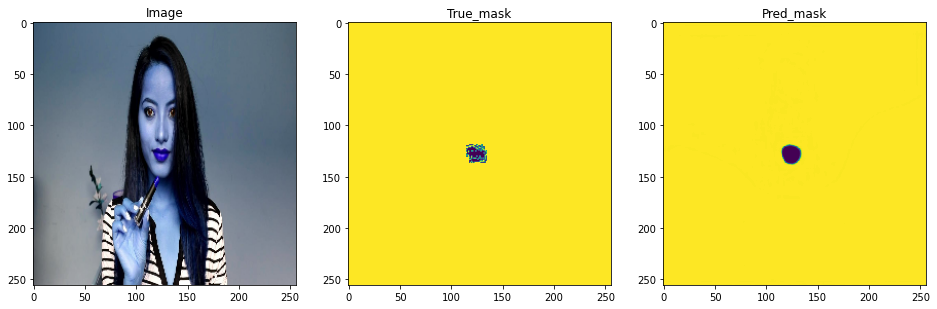

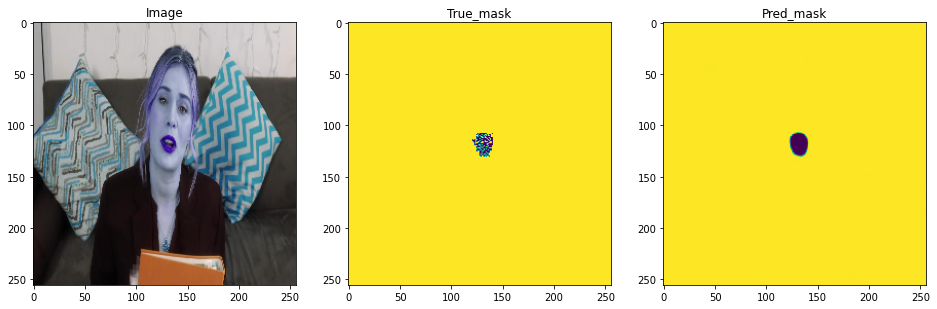

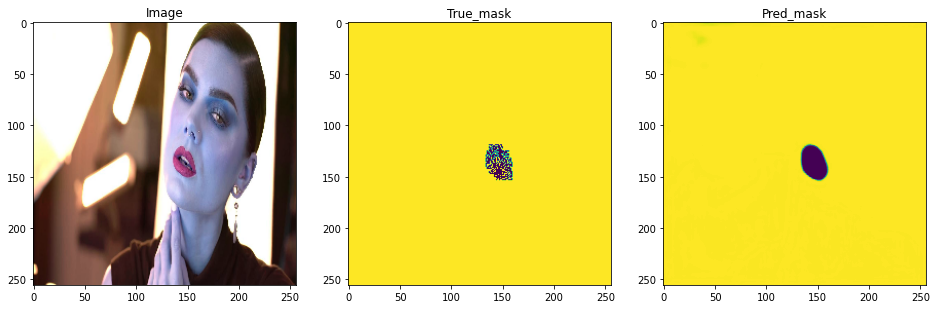

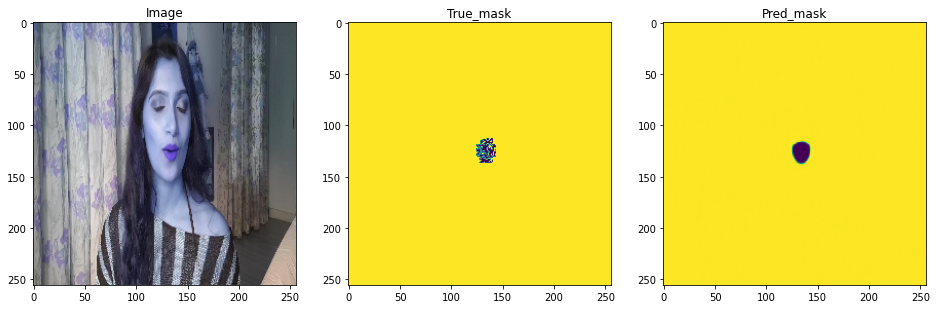

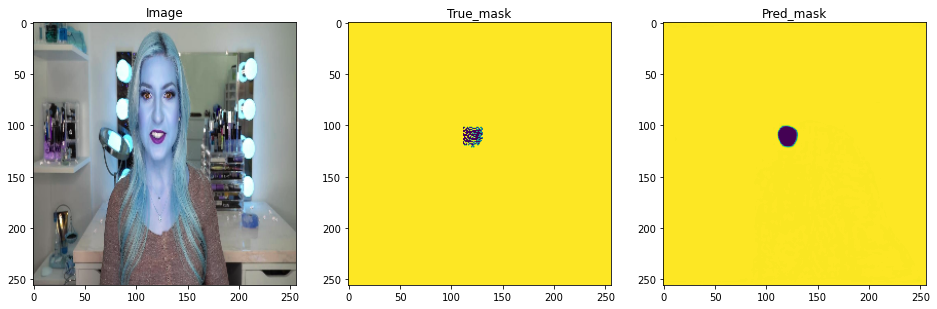

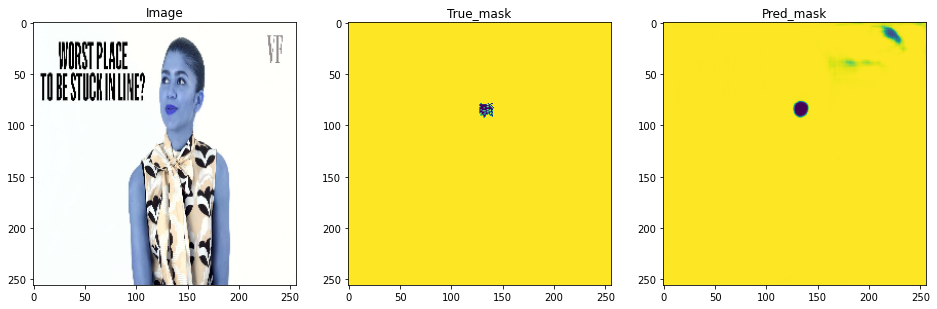

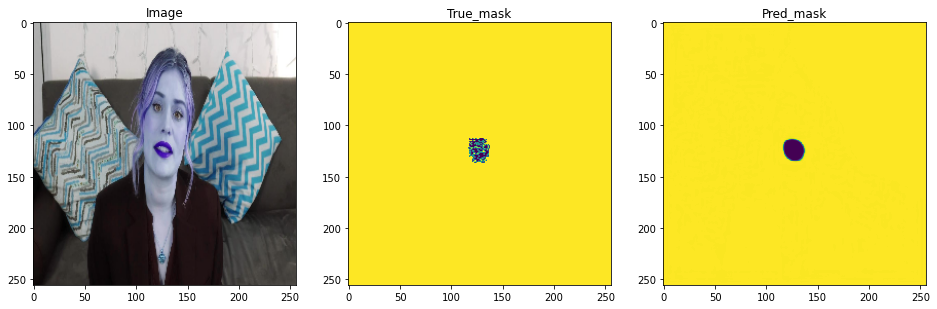

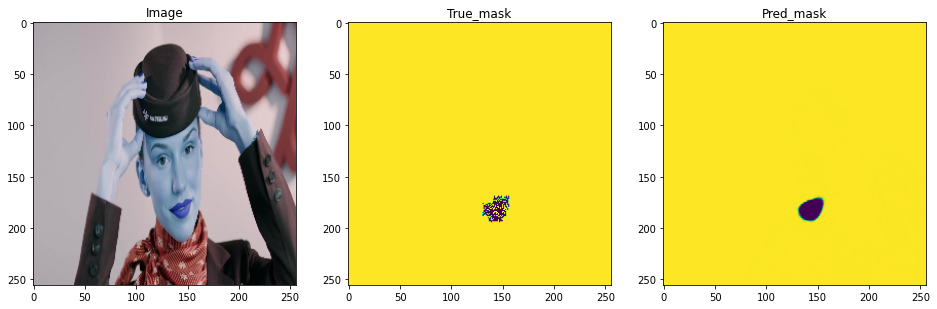

In [31]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')
    

Подскажите пожалуйтса очень долго крутил вертел код, размеченные маски почему-то пикселизируются сильно ,
метрика iou очень высокая глядя на лосс и скор метрики на валидации все выглядит нормально
но когда просматриваю результаты, предсказанная маска вылядит как мне кажется не очень.